In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def train_val_datasets():
    """Creates datasets for training and validation.

    Returns:
        (tf.data.Dataset, tf.data.Dataset): Training and validation datasets.
    """

    training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=os.getcwd(),
        image_size=(200,200),
        batch_size=16,
        label_mode="categorical",
        validation_split=0.15,
        subset="both",
        seed=42
    )

    return training_dataset, validation_dataset

In [3]:
training_dataset, validation_dataset = train_val_datasets()

Found 452 files belonging to 4 classes.
Using 385 files for training.
Using 67 files for validation.


In [4]:
# Define the preprocess function
def preprocess(image, label):
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label

# Apply the preprocessing to the datasets
train_dataset_scaled = training_dataset.map(preprocess)
validation_dataset_scaled = validation_dataset.map(preprocess)

In [5]:
# Optimize the datasets for training
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset_scaled
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (validation_dataset_scaled
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

In [6]:
def create_pre_trained_model():
    """Creates the pretrained inception V3 model

    Returns:
        tf.keras.Model: pre-trained model
    """

    local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
    pre_trained_model = tf.keras.applications.inception_v3.InceptionV3( 
        include_top=False, 
        input_shape=(200,200,3),
        weights=None
    ) 
    
    pre_trained_model.load_weights(local_weights_file)

    for layer in pre_trained_model.layers:
        layer.trainable = False
        
    return pre_trained_model

In [7]:
# Create the pre-trained model
pre_trained_model = create_pre_trained_model()

# Count the total number of parameters and how many are trainable
num_total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {num_total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [8]:
def output_of_last_layer(pre_trained_model):
    """Fetches the output of the last desired layer of the pre-trained model

    Args:
        pre_trained_model (tf.keras.Model): pre-trained model

    Returns:
        tf.keras.KerasTensor: last desired layer of pretrained model
    """

    last_desired_layer = pre_trained_model.get_layer('mixed7')
    last_output = last_desired_layer.output
    
    print('last layer output shape: ', last_output.shape)
    
    return last_output

In [9]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 10, 10, 768)


In [10]:
def create_final_model(pre_trained_model, last_output):
    """Creates final model by adding layers on top of the pretrained model.

    Args:
        pre_trained_model (tf.keras.Model): pre-trained inceptionV3 model
        last_output (tf.keras.KerasTensor): last layer of the pretrained model

    Returns:
        Tensorflow model: final model
    """

    x = tf.keras.layers.Flatten()(last_output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)  
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(4, activation='softmax')(x)        

    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=(x))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    return model

In [11]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 28,669,732 total parameters in this model.
There are 19,694,468 trainable parameters in this model.


In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 99, 99,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 99, 99,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 99, 99,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 97, 97,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 97, 97,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 97, 97,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 97, 97,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 97, 97,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 97, 97,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 48,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 48,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 46, 46,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 46, 46,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 46, 46,    │          0 │ batch_normalizat

 Total params: 28,669,732 (109.37 MB)

 Trainable params: 19,694,468 (75.13 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [13]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        if logs["accuracy"] >= 0.92 and logs["val_accuracy"] >= 0.9:
            self.model.stop_training = True

            print("\nReached 92% train accuracy and 90% validation accuracy, so cancelling training!")

In [14]:
# fit the model
history = model.fit(
    train_dataset_final,
    validation_data = validation_dataset_final,
    epochs = 10,
    verbose = 1,
    callbacks = [EarlyStoppingCallback()],
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.2406 - loss: 4.2255 - val_accuracy: 0.1642 - val_loss: 3.0152
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 640ms/step - accuracy: 0.3741 - loss: 2.6383 - val_accuracy: 0.2388 - val_loss: 1.7394
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 472ms/step - accuracy: 0.4979 - loss: 1.2959 - val_accuracy: 0.1791 - val_loss: 1.7172
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 343ms/step - accuracy: 0.6282 - loss: 0.9267 - val_accuracy: 0.1791 - val_loss: 1.8742
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 308ms/step - accuracy: 0.6579 - loss: 0.8971 - val_accuracy: 0.2090 - val_loss: 1.7924
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 327ms/step - accuracy: 0.6768 - loss: 0.9028 - val_accuracy: 0.2537 - val_loss: 1.8065
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 458ms/step - accuracy: 0.6986 - loss: 0.8073 - val_accuracy: 0.2239 - val_loss: 1.7808
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 469ms/step - accuracy: 0.8000 - loss: 0.6283 - val_accuracy:

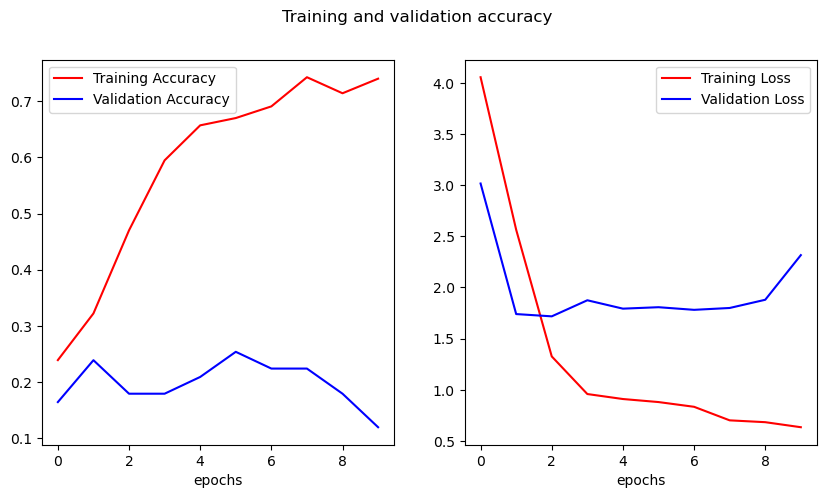

In [15]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()